# Checking the GPU name

In [ ]:
!nvidia-smi

Sat Aug  1 07:57:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Inistalling Apex (for mixed precision)

In [ ]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Cloning into 'apex'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7358 (delta 0), reused 0 (delta 0), pack-reused 7353
Receiving objects: 100% (7358/7358), 13.88 MiB | 6.51 MiB/s, done.
Resolving deltas: 100% (4972/4972), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-mvq0sfzr
Created temporary directory: /tmp/pip-req-tracker-hf_q4_ga
Created requirements tracker '/tmp/pip-req-tracker-hf_q4_ga'
Created temporary directory: /tmp/pip-install-1_7k6vl1
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-8x0x3v78
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-hf_q4_ga'
    Running se

In [ ]:
import os
%cd ..
os.getcwd()

/content


'/content'

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Setting up the workspace

In [ ]:
import shutil
import os

# shutil.copyfile('/content/drive/My Drive/Alzheimer/dataset.py' , 'dataset.py')
# shutil.copyfile('/content/drive/My Drive/Alzheimer/model.py' , 'model.py')
#shutil.copyfile('/content/drive/My Drive/Alzheimer/resnet(2+1)d_full_network_epoch_20_IS_112_acc_80.336_mcc_0.51862.pth' , 'model_fold_0.pth')


os.makedirs('data', exist_ok=True)

shutil.copyfile('/content/drive/My Drive/Alzheimer/3d_model.zip' , './3d_model.zip')
shutil.copyfile('/content/drive/My Drive/Alzheimer/micro_frames.zip' , './data/micro_frames.zip')
shutil.copyfile('/content/drive/My Drive/Alzheimer/traintestlist.zip' , './data/traintestlist.zip')
shutil.copyfile('/content/drive/My Drive/Alzheimer/bortoman/resnext.pth', './pretrained.pth')

!unzip data/micro_frames.zip;
!unzip data/traintestlist.zip;
!unzip 3d_model.zip;

os.remove("./data/micro_frames.zip")
os.remove('./data/traintestlist.zip')
os.remove('./3d_model.zip')

shutil.move('./micro_frames' , './data/micro_frames')
shutil.move('./traintestlist', './data/traintestlist')

Streaming output truncated to the last 5000 lines.
  inflating: micro_frames/667564/0.jpg  
  inflating: micro_frames/667564/1.jpg  
  inflating: micro_frames/667564/10.jpg  
  inflating: micro_frames/667564/11.jpg  
  inflating: micro_frames/667564/12.jpg  
  inflating: micro_frames/667564/13.jpg  
  inflating: micro_frames/667564/14.jpg  
  inflating: micro_frames/667564/15.jpg  
  inflating: micro_frames/667564/16.jpg  
  inflating: micro_frames/667564/17.jpg  
  inflating: micro_frames/667564/18.jpg  
  inflating: micro_frames/667564/19.jpg  
  inflating: micro_frames/667564/2.jpg  
  inflating: micro_frames/667564/20.jpg  
  inflating: micro_frames/667564/21.jpg  
  inflating: micro_frames/667564/22.jpg  
  inflating: micro_frames/667564/23.jpg  
  inflating: micro_frames/667564/24.jpg  
  inflating: micro_frames/667564/25.jpg  
  inflating: micro_frames/667564/26.jpg  
  inflating: micro_frames/667564/27.jpg  
  inflating: micro_frames/667564/28.jpg  
  inflating: micro_frames/66

'./data/traintestlist'

In [ ]:
import shutil
shutil.copyfile('/content/drive/My Drive/Alzheimer/resnet(2+1)d_full_network_epoch_11_IS_112_acc_88.158_mcc_0.70062_loss0.737.pth' , 'model_fold_1.pth')

'model_fold_1.pth'

# Dataset.py

In [ ]:
import glob
import random
import os
import numpy as np
import torch
import pandas as pd

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0])
std = np.array([1])


class Dataset(Dataset):
    def __init__(self, dataset_path, split_path, split_number, input_shape, sequence_length, training):
        self.training = training
        self.sequences, self.labels = self._extract_sequence_paths_and_labels(dataset_path, split_path, split_number, training) # creating a list of directories where the extracted frames are saved
        self.sequence_length = int(sequence_length) # Defining how many frames should be taken per video for training and testing
        self.label_names = ["Non-stalled", "Stalled"] #Getting the label names or name of the class
        self.num_classes = len(self.label_names) # Getting the number of class
        self.input_shape = input_shape
        self.transform = transforms.Compose(
            [
               	transforms.Grayscale(num_output_channels=3),
                transforms.Resize(input_shape[-2:], Image.BICUBIC),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        ) # This is to transform the datasets to same sizes, it's basically resizing -> converting the image to Tensor image -> then normalizing the image -> composing all the transformation in a single image


    def _extract_sequence_paths_and_labels(
        self, dataset_path, split_path="data/traintestlist", split_number=0, training=True
    ):
        """ Extracts paths to sequences given the specified train / test split """
        fn = f"fold_{split_number}_train.csv" if training else f"fold_{split_number}_test.csv"
        split_path = os.path.join(split_path, fn)
        df = pd.read_csv(split_path)
        file_name = df['filename'].values
        all_labels = df['class'].values
        sequence_paths = []
        classes = []
        for i , video_name in enumerate(file_name):
            seq_name = video_name.split(".mp4")[0]
            sequence_paths += [os.path.join(dataset_path, seq_name).replace('\\','/')]
            classes += [all_labels[i]]
        return sequence_paths, classes

    def _frame_number(self, image_path):
        """ Extracts frame number from filepath """
        image_path = image_path.replace('\\','/')
        try:
        	return int(image_path.split('/')[-1].split('.jpg')[0])
        except:
        	print("Got error while getting image number ....")
        	exit()

    def _pad_to_length(self, sequence, path):
        """ Pads the video frames to the required sequence length for small videos"""
        try:
        	left_pad = sequence[0]
        except:
        	print("Got error while padding ....")
        	exit()
        if self.sequence_length is not None:
            while len(sequence) < self.sequence_length:
                sequence.insert(0, left_pad)
        return sequence

    
    def __getitem__(self, index):
        sequence_path = self.sequences[index % len(self)]
        target = self.labels[index % len(self)]
        # Sort frame sequence based on frame number 
        image_paths_forward = sorted(glob.glob(sequence_path+'/*.jpg'), key=lambda path: self._frame_number(path))
        image_paths_backward = sorted(glob.glob(sequence_path+'/*.jpg'), key=lambda path: self._frame_number(path), reverse=True)
        
        

        # Pad frames of videos shorter than `self.sequence_length` to length

        image_paths_forward = self._pad_to_length(image_paths_forward, sequence_path)
        image_paths_backward = self._pad_to_length(image_paths_backward, sequence_path)
        total_image = len(image_paths_forward)
        if total_image >= self.sequence_length and total_image < (self.sequence_length+int(self.sequence_length//2)):
            midpoint = (total_image // 2)
            sample_interval = 1
            start_i = (midpoint-(self.sequence_length//2))
            end_i = start_i+self.sequence_length
        elif  total_image >= (self.sequence_length+int(self.sequence_length//2)):
            midpoint = (total_image // 2)
            sample_interval = 1
            start_i = (midpoint-(self.sequence_length//2)+int((self.sequence_length//2)//2))-1
            end_i = start_i+self.sequence_length
        else:
        	  start_i = 0
        	  end_i = total_image
        	  sample_interval = 1
            #flip = np.random.random() < 0.5
        # Extract frames as tensors
        image_sequence_forward = []
        image_sequence_backward = []
        for i in range(start_i, end_i, sample_interval):
            if self.sequence_length is None or len(image_sequence_forward) < self.sequence_length:
                img=Image.open(image_paths_forward[i])
                image_tensor_forward = self.transform(img)
                img=Image.open(image_paths_backward[i])
                image_tensor_backward = self.transform(img)
                # if flip:
                #     image_tensor = torch.flip(image_tensor, (-1,))
                image_sequence_forward.append(image_tensor_forward)
                image_sequence_backward.append(image_tensor_backward)
        image_sequence_forward = torch.stack(image_sequence_forward)
        image_sequence_forward = image_sequence_forward.view(3, self.sequence_length,self.input_shape[-2],self.input_shape[-2])
        image_sequence_backward = torch.stack(image_sequence_backward)
        image_sequence_backward = image_sequence_backward.view(3, self.sequence_length,self.input_shape[-2],self.input_shape[-2])
        
        return image_sequence_forward,image_sequence_backward, target

    def __len__(self):
        return len(self.sequences)



# Dataset with rotation(7 fixed degrees 45, 90, 135, 180, 225, 270, 315 degree)

In [ ]:
import glob
import random
import os
import numpy as np
import torch
import pandas as pd

from torch.utils.data import Dataset
from PIL import Image
from PIL import ImageFilter
import torchvision.transforms as transforms

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0])
std = np.array([1])


class Dataset(Dataset):
    def __init__(self, dataset_path, split_path, split_number, input_shape, sequence_length, training):
        self.training = training
        self.sequences, self.labels = self._extract_sequence_paths_and_labels(dataset_path, split_path, split_number, training) # creating a list of directories where the extracted frames are saved
        self.sequence_length = int(sequence_length) # Defining how many frames should be taken per video for training and testing
        self.label_names = ["Non-stalled", "Stalled"] #Getting the label names or name of the class
        self.num_classes = len(self.label_names) # Getting the number of class
        self.input_shape = input_shape
        self.transform = transforms.Compose(
            [
               	#transforms.Grayscale(num_output_channels=3),
                transforms.Resize(input_shape[-2:], Image.BICUBIC),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        ) # This is to transform the datasets to same sizes, it's basically resizing -> converting the image to Tensor image -> then normalizing the image -> composing all the transformation in a single image


    def _extract_sequence_paths_and_labels(
        self, dataset_path, split_path="data/traintestlist", split_number=0, training=True
    ):
        """ Extracts paths to sequences given the specified train / test split """
        fn = f"fold_{split_number}_train.csv" if training else f"fold_{split_number}_test.csv"
        split_path = os.path.join(split_path, fn)
        df = pd.read_csv(split_path)
        file_name = df['filename'].values
        all_labels = df['class'].values
        sequence_paths = []
        classes = []
        for i , video_name in enumerate(file_name):
            seq_name = video_name.split(".mp4")[0]
            sequence_paths += [os.path.join(dataset_path, seq_name).replace('\\','/')]
            classes += [all_labels[i]]
        return sequence_paths, classes

    def _frame_number(self, image_path):
        """ Extracts frame number from filepath """
        image_path = image_path.replace('\\','/')
        try:
        	return int(image_path.split('/')[-1].split('.jpg')[0])
        except:
        	print("Got error while getting image number ....")
        	exit()

    def _pad_to_length(self, sequence, path):
        """ Pads the video frames to the required sequence length for small videos"""
        try:
        	left_pad = sequence[0]
        except:
        	print("Got error while padding ....")
        	exit()
        if self.sequence_length is not None:
            while len(sequence) < self.sequence_length:
                sequence.insert(0, left_pad)
        return sequence

    
    def __getitem__(self, index):
        sequence_path = self.sequences[index % len(self)]
        target = self.labels[index % len(self)]
        # Sort frame sequence based on frame number 
        image_paths_forward = sorted(glob.glob(sequence_path+'/*.jpg'), key=lambda path: self._frame_number(path))
        image_paths_backward = sorted(glob.glob(sequence_path+'/*.jpg'), key=lambda path: self._frame_number(path), reverse=True)
        
        

        # Pad frames of videos shorter than `self.sequence_length` to length

        image_paths_forward = self._pad_to_length(image_paths_forward, sequence_path)
        image_paths_backward = self._pad_to_length(image_paths_backward, sequence_path)
        total_image = len(image_paths_forward)
        if total_image >= self.sequence_length and total_image < (self.sequence_length+int(self.sequence_length//2)):
            midpoint = (total_image // 2)
            sample_interval = 1
            start_i = (midpoint-(self.sequence_length//2))
            end_i = start_i+self.sequence_length
        elif  total_image >= (self.sequence_length+int(self.sequence_length//2)):
            midpoint = (total_image // 2)
            sample_interval = 1
            start_i = (midpoint-(self.sequence_length//2)+int((self.sequence_length//2)//2))-1
            end_i = start_i+self.sequence_length
        else:
        	  start_i = 0
        	  end_i = total_image
        	  sample_interval = 1
            #flip = np.random.random() < 0.5
        # Extract frames as tensors
        image_sequence_forward = []
        image_sequence_backward = []
        degrees_to_rotate = [45, 90, 135, 180, 225, 270, 315]
        rotate = np.random.random() < 0.5
        if rotate and self.training:
            rotate_angle = degrees_to_rotate[np.random.randint(0,7)]
        else:
            rotate_angle = 0
        
        for i in range(start_i, end_i, sample_interval):
            if self.sequence_length is None or len(image_sequence_forward) < self.sequence_length:
                img=Image.open(image_paths_forward[i])
                img=img.rotate(rotate_angle)
                img = img.filter(ImageFilter.MedianFilter)
                image_tensor_forward = self.transform(img)
                img=Image.open(image_paths_backward[i])
                img=img.rotate(rotate_angle)
                image_tensor_backward = self.transform(img)
                # if flip:
                #     image_tensor = torch.flip(image_tensor, (-1,))
                image_sequence_forward.append(image_tensor_forward)
                image_sequence_backward.append(image_tensor_backward)
        
        image_sequence_forward = torch.stack(image_sequence_forward)
        image_sequence_forward = image_sequence_forward.view(3, self.sequence_length,self.input_shape[-2],self.input_shape[-2])
        image_sequence_backward = torch.stack(image_sequence_backward)
        image_sequence_backward = image_sequence_backward.view(3, self.sequence_length,self.input_shape[-2],self.input_shape[-2])
        
        return image_sequence_forward,image_sequence_backward, target

    def __len__(self):
        return len(self.sequences)



# Model.py

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torch.autograd import Variable
from torchvision.models.video import r2plus1d_18

import torch.utils.model_zoo as model_zoo
import os
import sys




##############################
#         Encoder
##############################


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        resnet = r2plus1d_18(pretrained=False)
        # trained_kernel = resnet.stem[0].weight
        # new_conv = nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        # with torch.no_grad():
        #     new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*1, dim=1)
        #resnet.stem[0] = new_conv
        self.feature_extractor = nn.Sequential(*list(resnet.children())[0:2])
        self.feature_extractor_new=nn.Sequential(*list(resnet.children())[2:6])
        self.final = nn.Sequential(
            nn.AlphaDropout(0.4),
            nn.Linear(resnet.fc.in_features, latent_dim),
            nn.BatchNorm1d(latent_dim, momentum=0.01)
        )
    

    def forward(self, x):
        
        with torch.no_grad():
            x = self.feature_extractor(x)  
        x= self.feature_extractor_new(x)       
        x = x.view(x.size(0), -1)
        #print(self.final(x))
        
        return self.final(x)


##############################
#         ConvLSTM
##############################

#dim=-1 is the right most dimension

class ConvLSTM(nn.Module):
    def __init__(
        self, num_classes, latent_dim=512, hidden_dim=1024
    ):
        super(ConvLSTM, self).__init__()
        self.encoder = Encoder(latent_dim)
        hidden_dim2 = int(hidden_dim/2)
        hidden_dim3 = int(hidden_dim2/4)
        hidden_dim4 = int(hidden_dim3/4)
        hidden_dim5 = int(hidden_dim4/4)
        self.output_layers_new = nn.Sequential(
            nn.Linear(2*latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim, momentum=0.01),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim2),
            nn.ReLU(),
            nn.AlphaDropout(0.4),
            nn.Linear(hidden_dim2,hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3,hidden_dim4),
            nn.ReLU(),
            nn.Linear(hidden_dim4, hidden_dim5),
            nn.BatchNorm1d(hidden_dim5, momentum=0.01),
            nn.ReLU(),
            nn.AlphaDropout(0.4),
            nn.Linear(hidden_dim5, 1),
            nn.Sigmoid()
        )


    def forward(self, x, y):
        x = self.encoder(x)
        y = self.encoder(y)
        x = torch.cat((x,y),1)
        #x = self.inceptionresnetV2(x)
        #x = x.view(batch_size, seq_length, -1)
       
        return self.output_layers_new(x)

# Model (big architecture)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torch.autograd import Variable
from model import generate_model
#WEIGHTS_PATH = '/content/pretrained.pth' #pretrained weight for 3d models

import torch.utils.model_zoo as model_zoo
import os
import sys




##############################
#         Encoder
##############################


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        resnet = generate_model('resnext', 101, last_fc=False) #first parameter is the name of the model and 2nd parameter is the size of the model, for reference see "model.py"
        #resnet.load_state_dict(torch.load(WEIGHTS_PATH)['state_dict'])
        resnet = resnet.module
        # trained_kernel = resnet.stem[0].weight
        # new_conv = nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        # with torch.no_grad():
        #     new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*1, dim=1)
        #resnet.stem[0] = new_conv
        self.feature_extractor = nn.Sequential(*list(resnet.children())[0:4])
        self.feature_extractor_new=nn.Sequential(*list(resnet.children())[4:-1])
        self.final = nn.Sequential(
            nn.Linear(6144, latent_dim),
            nn.BatchNorm1d(latent_dim, momentum=0.01)
        ) #resnet.module.fc.in_features
    

    def forward(self, x):
        
        with torch.no_grad():
            x = self.feature_extractor(x)
        #with torch.no_grad():  
        x= self.feature_extractor_new(x)
        # print('\n\n\n\n\n\n')
        # print(x.size())      
        # print('\n\n\n\n\n\n') 
        x = x.view(x.size(0), -1)
        #print(self.final(x))
        
        return self.final(x)


##############################
#         ConvLSTM
##############################

#dim=-1 is the right most dimension

class ConvLSTM(nn.Module):
    def __init__(
        self, num_classes, latent_dim=512, hidden_dim=1024
    ):
        super(ConvLSTM, self).__init__()
        self.encoder = Encoder(latent_dim)
        hidden_dim2 = int(hidden_dim/2)
        hidden_dim3 = int(hidden_dim2/4)
        hidden_dim4 = int(hidden_dim3/4)
        hidden_dim5 = int(hidden_dim4/4)
        self.output_layers_new = nn.Sequential(
            nn.Linear(2*latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim, momentum=0.01),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2,hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3,hidden_dim4),
            nn.ReLU(),
            nn.Linear(hidden_dim4, hidden_dim5),
            nn.BatchNorm1d(hidden_dim5, momentum=0.01),
            nn.ReLU(),
            nn.Linear(hidden_dim5, 1),
            nn.Sigmoid()
        )


    def forward(self, x, y):
        x = self.encoder(x)
        y = self.encoder(y)
        x = torch.cat((x,y),1)
        #x = self.inceptionresnetV2(x)
        #x = x.view(batch_size, seq_length, -1)
       
        return self.output_layers_new(x)

#Batch-balance

In [ ]:
import torch
import torchvision
import torch.utils.data
import random


#Balance Batch generator for eighteen classes
class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
        self.dataset = {}
        self.balanced_max = 0
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = []
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
    
        self.keys = list(self.dataset.keys())
        self.currentkey = 0

    def __iter__(self):
        while len(self.dataset[self.keys[self.currentkey]]) > 0:
            yield self.dataset[self.keys[self.currentkey]].pop()
            self.currentkey = (self.currentkey + 1) % len(self.keys)

    
    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            (image_sequence,_, target) = dataset.__getitem__(idx)
            return target

    def __len__(self):
        return self.balanced_max*len(self.keys)

# Ranger Optimizer

In [ ]:
# Ranger deep learning optimizer - RAdam + Lookahead + Gradient Centralization, combined into one optimizer.

# https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# and/or
# https://github.com/lessw2020/Best-Deep-Learning-Optimizers

# Ranger has now been used to capture 12 records on the FastAI leaderboard.

# This version = 20.4.11

# Credits:
# Gradient Centralization --> https://arxiv.org/abs/2004.01461v2 (a new optimization technique for DNNs), github:  https://github.com/Yonghongwei/Gradient-Centralization
# RAdam -->  https://github.com/LiyuanLucasLiu/RAdam
# Lookahead --> rewritten by lessw2020, but big thanks to Github @LonePatient and @RWightman for ideas from their code.
# Lookahead paper --> MZhang,G Hinton  https://arxiv.org/abs/1907.08610

# summary of changes:
# 4/11/20 - add gradient centralization option.  Set new testing benchmark for accuracy with it, toggle with use_gc flag at init.
# full code integration with all updates at param level instead of group, moves slow weights into state dict (from generic weights),
# supports group learning rates (thanks @SHolderbach), fixes sporadic load from saved model issues.
# changes 8/31/19 - fix references to *self*.N_sma_threshold;
# changed eps to 1e-5 as better default than 1e-8.

import math
import torch
from torch.optim.optimizer import Optimizer, required


class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=6, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.use_gc = use_gc

        # level of gradient centralization
        self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_gradient_threshold == 1):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_gradient_threshold == 3):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                if grad.dim() > self.gc_gradient_threshold:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # compute mean moving avg
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size *
                                         group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(self.alpha, p.data - slow_p)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss


# Training

In [ ]:
import torch
import sys
import numpy as np
import itertools
#from model import *
#from dataset import *
from torch.utils.data import DataLoader
from torch.autograd import Variable
#import BalancedBatchSampler

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import matthews_corrcoef as mcc
#from apex import amp

torch.manual_seed(0)

MCC_SCORE = 0
Loss=.70

epoch_mcc=[]
epoch_confusion=[]
epoch_train_loss=[]
epoch_test_loss=[]



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    global epoch_confusion
    epoch_confusion.append(cm.ravel())
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    del(y_pred)
    del(y_true)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def test_model(epoch):
    """ Evaluate the model on the test set """
    print("")
    #defining numpy array to store the true labels and predicted labels
    y_true = np.array([])
    y_pred = np.array([])

    # Preparing the model for evaluation
    model.eval()
    test_metrics = {"loss": [], "acc": []}
    for batch_i, (Xf,Xb, y) in enumerate(test_dataloader):
        image_sequences_forward = Variable(Xf.to(device), requires_grad=False)
        image_sequences_forward = image_sequences_forward.half()
        image_sequences_backward = Variable(Xb.to(device), requires_grad=False)
        image_sequences_backward = image_sequences_backward.half()
        labels = Variable(y, requires_grad=False).to(device)
        y_true = np.append(y_true, labels.cpu().numpy())
        with torch.no_grad():
            

            # Get sequence predictions
            predictions = model(image_sequences_forward, image_sequences_backward)
            

            acc = torch.tensor([0 if i<=0.5 else 1 for i in predictions]).to(device)
            



            y_pred = np.append(y_pred, acc.detach().cpu().numpy())
        # Compute metrics
        
        acc = 100 * (acc.detach() == labels).cpu().numpy().mean()
        labels = labels.view(-1,1)
        loss =   cls_criterion(predictions.float(), labels.float()).item()
        # Keep track of loss and accuracy
        test_metrics["loss"].append(loss)
        test_metrics["acc"].append(acc)
        # Log test performance
        sys.stdout.write(
            "\rTesting -- [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
            % (
                batch_i,
                len(test_dataloader),
                loss,
                np.mean(test_metrics["loss"]),
                acc,
                np.mean(test_metrics["acc"]),
            )
        )
        del(Xf)
        del(Xb)
        del(y)
        del(image_sequences_forward)
        del(image_sequences_backward)
        del(labels)
        del(predictions)
        del(loss)

    final_acc=round(np.mean(test_metrics["acc"]),3)
    global epoch_train_loss
    epoch_test_loss.append(np.mean(test_metrics["loss"]))

    

    # Save model checkpoint
    
    # Using the learning rate scheduler while monitoring Loss and printing the learning rate after every epoch
    for param_group in optimizer.param_groups:
        print("\nCurrent Learning Rate is : " + str(param_group['lr']))
    model.train()
    print("")
    # Getting the P, R and F score for evaluation and plotting the confusion matrix and saving that matrix
    mcc_score = round(mcc(y_true.astype(int), y_pred.astype(int)), 5)


    mcc_score_str = "MCC Score: " + str(mcc_score) + "\n\n"

    plot_title = mcc_score_str + "Confusion matrix, Without Normalization\n"

    
    class_names = ['Non-stalled', 'Stalled']
    class_names = np.array(class_names)
    plot_confusion_matrix(y_true.astype(int), y_pred.astype(int), classes=class_names, title=plot_title)

    # Save model checkpoint
    global MCC_SCORE
    global Loss

    if MCC_SCORE < mcc_score or epoch%2==0 :
        if MCC_SCORE < mcc_score:
            MCC_SCORE = mcc_score
        if Loss>epoch_train_loss[-1]:
          Loss=epoch_train_loss[-1]    
        os.makedirs("model_checkpoints", exist_ok=True)
        # checkpoint = {
        #     'model': model.state_dict(),
        #     'optimizer': optimizer.state_dict(),
        #     'amp': amp.state_dict()
        # }
        # torch.save(checkpoint, f"model_checkpoints/resnet(2+1)d_rotate_epoch_{epoch}_IS_112_acc_{final_acc}_mcc_{mcc_score}_loss{round(epoch_train_loss[-1], 3)}.pth")

        torch.save(model.state_dict(),f"model_checkpoints/wideresnet50_rotate_epoch_{epoch}_IS_112_acc_{final_acc}_mcc_{mcc_score}_loss{round(epoch_train_loss[-1], 3)}.pth" )
        #shutil.copyfile(f"model_checkpoints/resnet(2+1)d_full_network_epoch_{epoch}_IS_112_acc_{final_acc}_mcc_{mcc_score}_loss{epoch_train_loss[-1]}.pth","/content/drive/My Drive/Clogg Loss/Model_weight")

    os.makedirs("confusion_matrix", exist_ok=True)
    plt.savefig(f"confusion_matrix/score{epoch}with_accuracy{final_acc}_mcc_{mcc_score}.png")
    plt.clf()
    global epoch_mcc
    epoch_mcc.append(mcc_score)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = 'data/micro_frames'
split_path = 'data/traintestlist'
split_number = 3
sequence_length=40
num_epochs = 27
batch_size = 8
img_dim = 112
channels = 3
latent_dim = 512
hidden_dim=1024
checkpoint_model = '/content/model_checkpoints/wideresnet50_rotate_epoch_1_IS_112_acc_84.143_mcc_0.66768_loss0.082.pth'


#image shape
image_shape = (channels, img_dim, img_dim)



# Define training set
train_dataset = Dataset(
    dataset_path=dataset_path,
    split_path=split_path,
    sequence_length=sequence_length,
    split_number=split_number,
    input_shape=image_shape,
    training=True,
)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers=4)
# Define test set
test_dataset = Dataset(
    dataset_path=dataset_path,
    split_path=split_path,
    split_number=split_number,
    sequence_length=sequence_length,
    input_shape=image_shape,
    training=False,
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

#cls_weight = torch.tensor([1.6994328922495274])

# Classification criterion
cls_criterion = nn.BCEWithLogitsLoss().to(device)
# Define network
model = ConvLSTM(
    num_classes=2,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim
)
#primarily setting the attention to False 

model = model.to(device)

model.half()  
for layer in model.modules():
  if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d) or isinstance(layer, nn.BatchNorm3d):
    layer.float()


optimizer=Ranger(model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, eps=1e-04, weight_decay=1e-04)

# Initialization
# opt_level = 'O2'
# model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

# Add weights from checkpoint model if specified
if checkpoint_model:
    model.load_state_dict(torch.load(checkpoint_model))
    # checkpoint = torch.load(checkpoint_model)
    # model.load_state_dict(checkpoint['model'])
    # optimizer.load_state_dict(checkpoint['optimizer'])
    # amp.load_state_dict(checkpoint['amp'])


accumulation_step = 8
optimizer.zero_grad()
#Stating the epoch
for epoch in range(num_epochs):
    #epoch+=9
    epoch_metrics = {"loss": [], "acc": []}
    print(f"--- Epoch {epoch}---")
    for batch_i, (Xf,Xb, y) in enumerate(train_dataloader):
        if Xf.size(0) == 1:
            continue



        image_sequences_forward = Variable(Xf.to(device), requires_grad=True)
        image_sequences_forward = image_sequences_forward.half()
        image_sequences_backward = Variable(Xb.to(device), requires_grad=True)
        image_sequences_backward = image_sequences_backward.half()
        labels = Variable(y.to(device), requires_grad=False)
        
        

        #optimizer.zero_grad()

        
        # Get sequence predictions
        predictions = model(image_sequences_forward, image_sequences_backward)

        

        
        # Compute metrics
        acc = torch.tensor([0 if i<=0.5 else 1 for i in predictions]).to(device)
        acc = 100 * (acc.detach() == labels).cpu().numpy().mean()
        labels = labels.view(-1, 1)
        loss = cls_criterion.forward(predictions.float(), labels.float())
        
        
        # with amp.scale_loss(loss, optimizer) as scaled_loss:
        #     scaled_loss = scaled_loss/accumulation_step
        #     scaled_loss.backward()

        
        loss = loss/accumulation_step
        loss.backward()
        if (batch_i+1) % accumulation_step == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Keep track of epoch metrics
        epoch_metrics["loss"].append(loss.item())
        epoch_metrics["acc"].append(acc)

        # Determine approximate time left
        batches_done = epoch * len(train_dataloader) + batch_i
        batches_left = num_epochs * len(train_dataloader) - batches_done

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
            % (
                epoch,
                num_epochs,
                batch_i,
                len(train_dataloader),
                loss.item(),
                np.mean(epoch_metrics["loss"]),
                acc,
                np.mean(epoch_metrics["acc"]),
            )
        )
        del(Xf)
        del(Xb)
        del(y)
        del(image_sequences_forward)
        del(image_sequences_backward)
        del(labels)
        del(predictions)
        del(loss)


        # Empty cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    global epoch_train_loss
    epoch_train_loss.append(np.mean(epoch_metrics["loss"]))  
    # Evaluate the model on the test set
    test_model(epoch)
    #train_dataloader = DataLoader(train_dataset, sampler=BalancedBatchSampler(train_dataset),batch_size= batch_size, shuffle=False, num_workers=4)




Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
--- Epoch 0---
[Epoch 0/27] [Batch 193/225] [Loss: 0.102839 (0.099703), Acc: 75.00% (73.39%)]

In [ ]:
shutil.copyfile('/content/drive/My Drive/Alzheimer/bortoman/resnet(2+1)d_rotate_epoch_4_IS_112_acc_89.81_mcc_0.75587_loss0.095.pth', './fold_1.pth')

'./fold_1.pth'

In [ ]:
import shutil

shutil.rmtree('/content/confusion_matrix')
shutil.rmtree('/content/model_checkpoints')


In [ ]:
import pandas
import shutil
df = pandas.DataFrame(data={"epoch_train_loss": epoch_train_loss, "epoch_test_loss": epoch_test_loss,"epoch_mcc":epoch_mcc,"epoch_confusion":epoch_confusion})
df.to_csv("performance.csv", sep=',',index=False)
#shutil.copy('/content/performance.csv', '/content/drive/My Drive/Clogg Loss/Performance')  

In [ ]:
len(epoch_confusion)

27

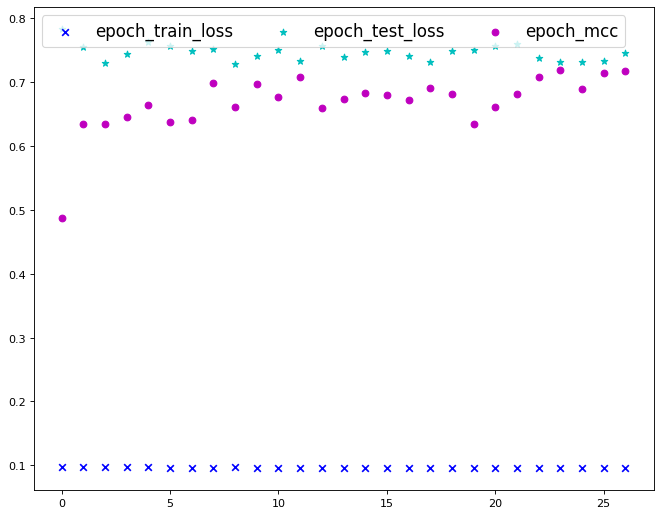

In [ ]:
colors = ['b', 'c', 'm']

perform=pd.read_csv("performance.csv")
x=range(len(perform))

plt.figure(figsize=(10,8), dpi=80)
lo = plt.scatter(x,perform.epoch_train_loss, marker='x', color=colors[0])
ll = plt.scatter(x,perform.epoch_test_loss, marker='*', color=colors[1])
l  = plt.scatter(x,perform.epoch_mcc, marker='o', color=colors[2])

plt.legend((lo, ll, l),
           ('epoch_train_loss', 'epoch_test_loss', 'epoch_mcc'),
           scatterpoints=1,
           loc='upper left',
           ncol=3,
           fontsize=15)


#plt.savefig(f"/content/drive/My Drive/Clogg Loss/Performance/Performance.png")
plt.show()

In [ ]:
o[0]

tensor([[0.1279],
        [0.1271]], grad_fn=<SelectBackward>)

In [ ]:
zi = torch.mul(z1, o[0])
z = [z1,z2,z3]
z_ = torch.cat(z, 1)

In [ ]:
z_.shape

torch.Size([2, 3072])

In [ ]:
import shutil
shutil.copyfile('/content/model_checkpoints/resnet(2+1)d_full_network_epoch_4_IS_112_acc_79.441_mcc_0.48374.pth' , '/content/drive/My Drive/Clogg Loss/Model_weight')

IsADirectoryError: ignored

In [ ]:
shutil.copyfile('./model_checkpoints/resnet(2+1)d_full_network_epoch_{epoch}_IS_112_acc_{final_acc}_mcc_{mcc_score}_loss{epoch_train_loss[-1]}.pth',"/content/drive/My Drive/Clogg Loss/Model_weight")

FileNotFoundError: ignored

In [ ]:
 shutil.rmtree("./apex")